Notebook criado para o desenvolvimento de Machine Learning do projeto "Crimes em Chicago", produzido para a disciplina 'Projeto Integrador III', do curso de Tecnologia em Big Data para Negócios, da FATEC Ipiranga. 

Instala-se a biblioteca psycopg2, para a conexão do notebook com o banco de dados PostgreSQL no qual se encontra o data warehouse do projeto.

In [1]:
%pip install psycopg2
%pip install statsmodels

Note: you may need to restart the kernel to use updated packages.


In [1]:
import psycopg2 as ps2 #para conexão do IPYNB com o DW
import pandas as pd #para manipulação dos dados extraídos do DW
import random #para uso na criação de datasets de sample
#para uso no machine learning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
#para uso nas previsões temporais
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX

Iniciam-se variáveis com os parametros necessários para a criação de uma string de conexão com o banco de dados.

In [2]:
db_host = 'nome do servidor'
db_port = 'porta'
db_name = 'nome do database'
db_user = 'nome do usuario'
db_password = 'senha do usuario'

Criação da string de conexão, a partir dos parametros passados anteriormente.

In [3]:
conexao = ps2.connect(
    host=db_host,
    port=db_port,
    dbname=db_name,
    user=db_user,
    password=db_password
)

Transformação das tabelas do banco de dados em dataframes.

In [4]:
query = "SELECT * FROM dim_Localizacao"
dfLocalizacao = pd.read_sql(query, conexao)
dfLocalizacao

C:\Users\rsouz\AppData\Local\Temp\ipykernel_25004\722260133.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  dfLocalizacao = pd.read_sql(query, conexao)


,beat,distrito
0,111,1
1,112,1
2,113,1
3,114,1
4,121,1
...,...,...
270,2532,25
271,2533,25
272,2534,25
273,2535,25


In [5]:
query = "SELECT * FROM dim_tipoCrime"
dfTipoCrime = pd.read_sql(query, conexao)
dfTipoCrime

C:\Users\rsouz\AppData\Local\Temp\ipykernel_25004\3829423016.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  dfTipoCrime = pd.read_sql(query, conexao)


,iucr,categoriacrime,descricaocrime
0,0110,HOMICIDE,FIRST DEGREE MURDER
1,0130,HOMICIDE,SECOND DEGREE MURDER
2,0141,HOMICIDE,INVOLUNTARY MANSLAUGHTER
3,0142,HOMICIDE,RECKLESS HOMICIDE
4,0261,CRIMINAL SEXUAL ASSAULT,AGGRAVATED - HANDGUN
...,...,...,...
405,5121,OTHER OFFENSE,ARSONIST - ANNUAL REGISTRATION
406,5122,OTHER OFFENSE,ARSONIST - FAIL TO REGISTER NEW ADDRESS
407,5130,OTHER OFFENSE,VIOLENT OFFENDER - DUTY TO REGISTER
408,5131,OTHER OFFENSE,VIOLENT OFFENDER - ANNUAL REGISTRATION


In [6]:
query = "SELECT * FROM dim_Tempo"
dfTempo = pd.read_sql(query, conexao)
dfTempo

C:\Users\rsouz\AppData\Local\Temp\ipykernel_25004\2909130873.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  dfTempo = pd.read_sql(query, conexao)


,datatempo,ano,mes,dia
0,2000-01-01,2000,1,1
1,2000-01-02,2000,1,2
2,2000-01-03,2000,1,3
3,2000-01-04,2000,1,4
4,2000-01-05,2000,1,5
...,...,...,...,...
9492,2025-12-27,2025,12,27
9493,2025-12-28,2025,12,28
9494,2025-12-29,2025,12,29
9495,2025-12-30,2025,12,30


In [7]:
query = "SELECT * FROM fato_Casos ORDER BY RANDOM() LIMIT 10000" # selecionada apenas uma amostra da tabela original
dfCasos = pd.read_sql(query, conexao)
dfCasos

C:\Users\rsouz\AppData\Local\Temp\ipykernel_25004\4199023755.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  dfCasos = pd.read_sql(query, conexao)


,idcasos,numerocaso,data,iucr,descricaolocal,prisao,domestico,beat,ala,areacomunitaria,dataultimaatualizacao,latitude,longitude,local
0,6288536,HP376024,2008-06-05,1563,TAXICAB,False,False,1411,33.0,21.0,2018-02-28,41.937691,-87.701457,"(41.937690883, -87.701456527)"
1,11195359,JB104546,2018-01-04,0870,STREET,False,False,511,9.0,49.0,2018-05-04,41.707092,-87.629208,"(41.707092129, -87.629207997)"
2,9445188,HW589258,2013-12-30,0610,RESIDENCE,True,False,1634,38.0,15.0,2018-02-10,41.939562,-87.760511,"(41.939562155, -87.760510775)"
3,8651066,HV326354,2012-06-08,0910,STREET,False,False,2533,37.0,23.0,2016-02-04,41.909746,-87.736835,"(41.909746302, -87.736835292)"
4,4658764,HM157633,2006-02-01,2070,ALLEY,True,False,1132,24.0,26.0,2018-02-28,41.871563,-87.730563,"(41.871563069, -87.730563179)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9915535,HY105438,2015-01-05,0486,APARTMENT,False,True,323,6.0,69.0,2018-02-10,41.761121,-87.613949,"(41.761120917, -87.613949135)"
9996,3464366,HK533951,2004-08-03,0486,APARTMENT,False,True,1512,29.0,25.0,2018-02-28,41.887973,-87.773319,"(41.887973344, -87.773318988)"
9997,7997186,HT228368,2011-03-31,0630,RESIDENCE,False,False,1631,36.0,17.0,2018-02-10,41.938514,-87.816538,"(41.93851352, -87.81653768)"
9998,2918443,HJ596151,2003-08-29,1310,PARKING LOT/GARAGE(NON.RESID.),False,False,735,17.0,67.0,2018-02-28,41.761982,-87.674671,"(41.761981793, -87.674670627)"


Após os dados necessários serem extraídos, fecha-se a conexão com o banco de dados.

In [8]:
conexao.close()

**Previsão da probabilidade de prisões**

In [10]:
# criando um dataframe do resultado do join entre dfCasos e dfTipoCrime
casos_tipoCrime = dfCasos.merge(dfTipoCrime, left_on='iucr', right_on='iucr')

In [34]:
# funcao para previsao de probabilidade de prisao

def previsao_prisao(categoria,area):
  X = casos_tipoCrime[['categoriacrime', 'areacomunitaria']]
  y = casos_tipoCrime['prisao']

  # dividindo os dados em conjunto de treinamento e teste
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  # criando um transformador para lidar com variáveis categóricas
  preprocessor = ColumnTransformer(
      transformers=[
          ('cat', OneHotEncoder(handle_unknown='ignore'), ['categoriacrime', 'areacomunitaria'])
      ])

  # criando o modelo de regressão logística
  model = Pipeline([
      ('preprocessor', preprocessor),
      ('classifier', LogisticRegression())
  ])

  # treinando o modelo
  model.fit(X_train, y_train)

  # criando um novo dataframe com os valores de categoriacrime e área comunitária
  new_data = pd.DataFrame({'categoriacrime': [categoria], 'areacomunitaria': [area]})

  # usando o modelo para prever a probabilidade de prisão
  probabilidade_prisao = model.predict_proba(new_data)[:, 1]

  print(f"The probability of arrest for {categoria.lower()} in the Community Area {int(area)} is {probabilidade_prisao[0]:.2%}.")

In [35]:
previsao_prisao('THEFT', 61.0)

The probability of arrest for theft in the Community Area 61 is 12.56%.


**Previsão de tendências temporais**

In [29]:
# contar quantidade de casos por dia e agrupar em um dataframe
date_counts = dfCasos['data'].value_counts().reset_index()

# renomeando as colunas
date_counts.columns = ['data', 'contagemCasos']

# ordenando pela data - ascendente
date_counts = date_counts.sort_values(by='data')

# convertendo a coluna 'data' para o formato datetime
date_counts['data'] = pd.to_datetime(date_counts['data'])

# filtrar apenas datas a partir de outubro de 2002
date_counts_filtered = date_counts[date_counts['data'] > '2002-09-30']

# indicar a coluna 'data' como índice
date_counts_filtered.set_index('data', inplace=True)

# agrupar por mes
monthly_counts = date_counts_filtered.resample('M').sum()

# mostra o dataframe resultante
monthly_counts.head()


,contagemCasos
data,
2002-10-31,57
2002-11-30,46
2002-12-31,46
2003-01-31,44
2003-02-28,41


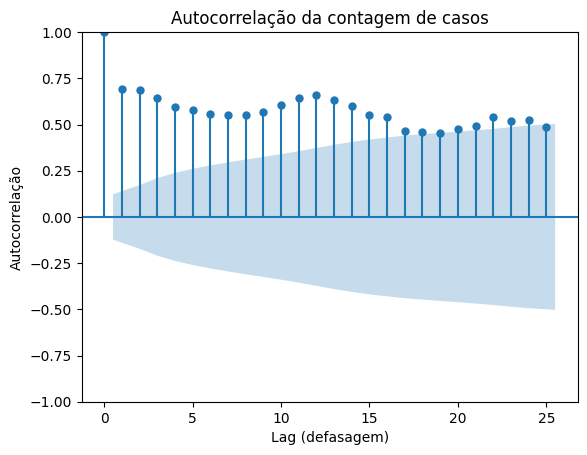

In [31]:
# plotar grafico de autocorrelacao
plot_acf(monthly_counts['contagemCasos'])
plt.title('Autocorrelação da contagem de casos')
plt.xlabel('Lag (defasagem)')
plt.ylabel('Autocorrelação')
plt.show()


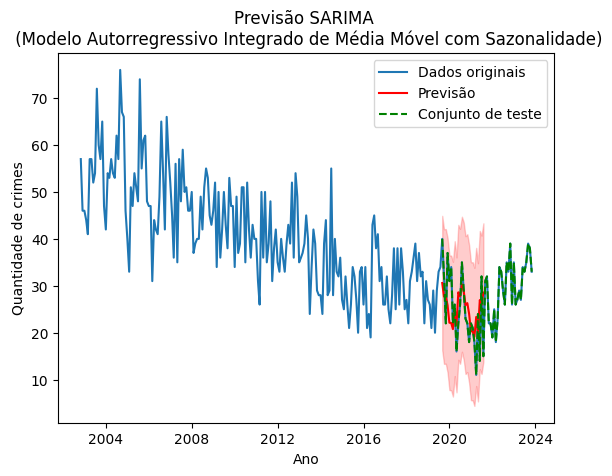

In [36]:
# ajuste do modelo SARIMA (Modelo Autorregressivo Integrado de Média Móvel com Sazonalidade) no conjunto de treinamento
model = SARIMAX(train['contagemCasos'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
results = model.fit()

# número de passos para prever até o final do ano de 2024 (mensalmente)
forecast_steps = 12 * (2024 - test.index[-1].year + 1)

# previsão de valores futuros no conjunto de teste
forecast = results.get_forecast(steps=forecast_steps)

# obtenção dos valores de previsão e intervalos
forecast_values = forecast.predicted_mean
forecast_intervals = forecast.conf_int()

# plotagem dos dados originais, da previsão e do conjunto de teste
plt.plot(monthly_counts.index, monthly_counts['contagemCasos'], label='Dados originais')
plt.plot(forecast_values.index, forecast_values, color='red', label='Previsão')
plt.fill_between(forecast_intervals.index, forecast_intervals.iloc[:, 0], forecast_intervals.iloc[:, 1], color='red', alpha=0.2)
plt.plot(test.index, test['contagemCasos'], label='Conjunto de teste', linestyle='dashed', color='green')
plt.title('Previsão SARIMA \n (Modelo Autorregressivo Integrado de Média Móvel com Sazonalidade)')
plt.xlabel('Ano')
plt.ylabel('Quantidade de crimes')
plt.legend()
plt.show()
